In [2]:
from abc import ABC, abstractmethod
from typing import Optional, List, Type, Tuple, Dict
import math

import numpy as np
from matplotlib import pyplot as plt
import matplotlib.cm as cm
from matplotlib.axes._axes import Axes
import torch
import torch.distributions as D
from torch.func import vmap, jacrev
from tqdm import tqdm
import seaborn as sns
from sklearn.datasets import make_moons, make_circles
# === Imports (add to existing imports) ===
import scanpy as sc
import anndata
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from torch import nn
import math

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [3]:
adata_path = "/Users/dhruva/dtu/DL_VCC/data/adata_Training.h5ad" 

In [5]:

# ============================
# 1) LOAD THE DATA
# ============================
adata = sc.read_h5ad(adata_path)
print("Loaded:", adata)


# ============================
# 3) SUBSAMPLING
# ============================

df = adata.obs.copy()

# PARAMETERS YOU CONTROL
n_perts = 10          # number of perturbations to sample
cells_per_pert = 40   # number of cells per perturbation
n_controls = 10       # number of control cells

# list all perturbations except controls
all_perts = df["target_gene"].unique().tolist()
all_perts = [p for p in all_perts if p != "non-targeting"]

# randomly select N perturbations
chosen_perts = np.random.choice(all_perts, size=n_perts, replace=False)
print("Chosen perturbations:", chosen_perts)

cells_keep = []

# ---- sample controls ----
control_cells = df.index[df["target_gene"] == "non-targeting"]
control_sub = np.random.choice(control_cells, size=n_controls, replace=False)
cells_keep.extend(control_sub)

# ---- sample K cells from each perturbation ----
for p in chosen_perts:
    ids = df.index[df["target_gene"] == p]
    if len(ids) < cells_per_pert:
        print(f"Skipping {p}: only {len(ids)} cells available.")
        continue
    sampled = np.random.choice(ids, size=cells_per_pert, replace=False)
    cells_keep.extend(sampled)

# Final dataset
adata_sub = adata[cells_keep].copy()
print("Final subset:", adata_sub)
print("Total cells:", adata_sub.n_obs)


Loaded: AnnData object with n_obs × n_vars = 221273 × 18080
    obs: 'target_gene', 'guide_id', 'batch'
    var: 'gene_id'
Chosen perturbations: ['PRR12' 'IRF3' 'DHX36' 'TAF13' 'METTL17' 'EID2' 'PHF14' 'RAB3B' 'MED13L'
 'BIRC2']
Final subset: AnnData object with n_obs × n_vars = 410 × 18080
    obs: 'target_gene', 'guide_id', 'batch'
    var: 'gene_id'
Total cells: 410


/Users/dhruva/.local/share/mamba/envs/deep_learning/lib/python3.12/functools.py:912: UserWarning: zero-centering a sparse array/matrix densifies it.
  return dispatch(args[0].__class__)(*args, **kw)


(410, 50)


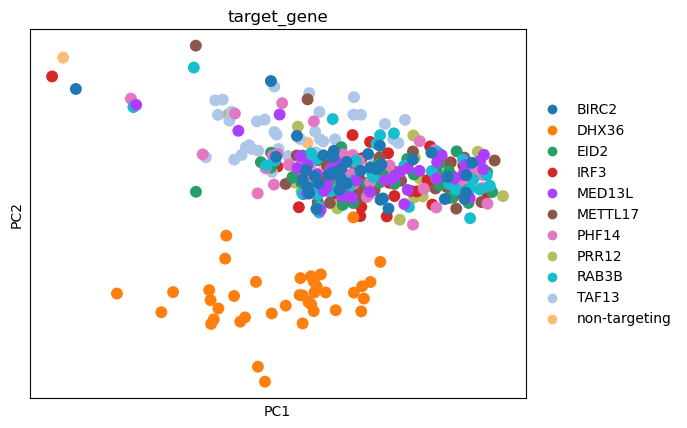

In [6]:

# --- 1) Normalize (CPM-like) ---
sc.pp.normalize_total(adata_sub, target_sum=1e4)

# --- 2) Log-transform ---
sc.pp.log1p(adata_sub)

# --- 3) Optional: select highly variable genes ---
sc.pp.highly_variable_genes(adata_sub, n_top_genes=2000, subset=True)

# --- 4) Scale genes (important for PCA!) ---
sc.pp.scale(adata_sub, max_value=10)

# --- 5) Run PCA ---
sc.tl.pca(adata_sub, n_comps=50)

# --- 6) Inspect ---
print(adata_sub.obsm["X_pca"].shape)
sc.pl.pca(adata_sub, color="target_gene")